# Лабораторная работа №3
## Распознавание изображений на примере рукописных цифр

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y.

In [5]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from matplotlib import pyplot as plt
%matplotlib inline

data = load_digits()
X, y = data.data, data.target

X[10,:].reshape([8,8])

array([[ 0.,  0.,  1.,  9., 15., 11.,  0.,  0.],
       [ 0.,  0., 11., 16.,  8., 14.,  6.,  0.],
       [ 0.,  2., 16., 10.,  0.,  9.,  9.,  0.],
       [ 0.,  1., 16.,  4.,  0.,  8.,  8.,  0.],
       [ 0.,  4., 16.,  4.,  0.,  8.,  8.,  0.],
       [ 0.,  1., 16.,  5.,  1., 11.,  3.,  0.],
       [ 0.,  0., 12., 12., 10., 10.,  0.,  0.],
       [ 0.,  0.,  1., 10., 13.,  3.,  0.,  0.]])

In [2]:
import sklearn
sklearn.__version__

'1.3.1'

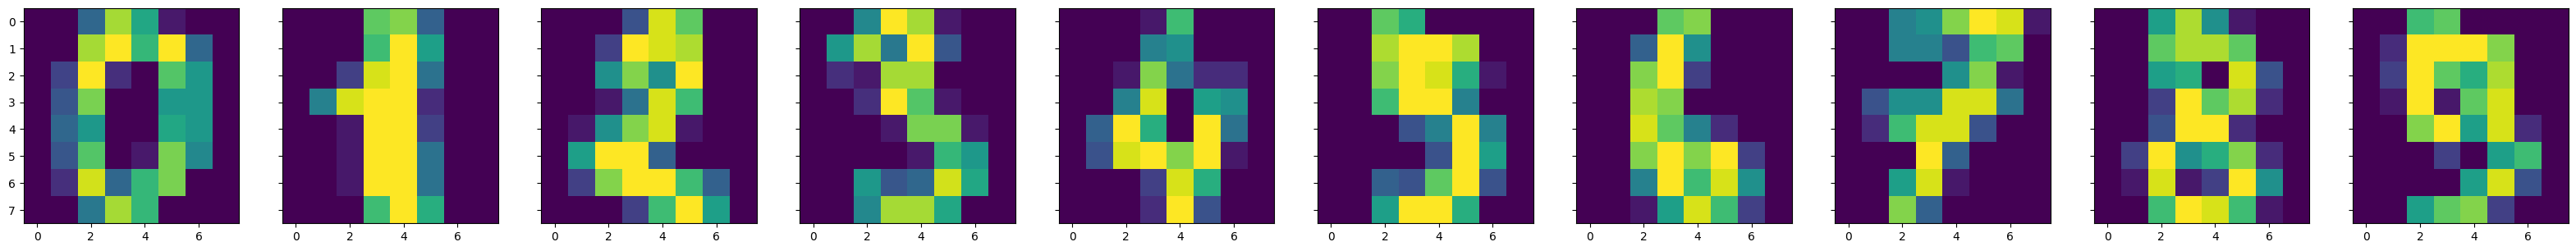

In [14]:
f, axes = plt.subplots(1, 10, sharey=True, figsize=(40,4))
for i in range(10):
    axes[i].imshow(X[i,:].reshape([8,8]))

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Используйте k=10, чтобы полученные оценки качества имели небольшой разброс. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Получите среднее значение (которое и будет оценкой качества работы) массива, который возвращает cross_val_score.

In [16]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Обучайтесь только на train выборке. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100. Качество классификации новой модели - среднее значение cross_val_score. Сравните работу композиции деревьев с одним решающем деревом.

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
np.mean(cross_val_score(dt, X, y, cv=10))

0.8285878336436996

In [20]:
bc = BaggingClassifier(dt, n_estimators=100)
bc.fit(X_train, y_train)
print(np.mean(cross_val_score(bc, X, y, cv=10)))
bc1 = BaggingClassifier(dt, n_estimators=1)
bc1.fit(X_train, y_train)
print(np.mean(cross_val_score(bc1, X, y, cv=10)))

0.9276225946617007
0.806306641837368


Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Каково качество работы алгоритма?

In [7]:
import math
bc_sqrt = BaggingClassifier(dt, n_estimators=100, max_features=int(math.sqrt(X.shape[1])))
bc_sqrt.fit(X_train, y_train)
np.mean(cross_val_score(bc_sqrt, X, y, cv=10))

0.9270887647423958

Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn. Попробуйте выбирать опять же $\sqrt{d}$ признаков. Какое теперь качество полученного классификатора?

In [10]:
dt_sqrt = DecisionTreeClassifier(max_features=int(np.sqrt(X.shape[1])))
bc_dt_sqrt = BaggingClassifier(dt_sqrt, n_estimators=100)
bc_dt_sqrt.fit(X_train, y_train)
np.mean(cross_val_score(bc_dt_sqrt, X, y, cv=10))

0.9482464307883302

Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest. Сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble.

In [11]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
np.mean(cross_val_score(rf, X, y, cv=10))

0.9499130974549969

Изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров на обучающей и тестовой выборке

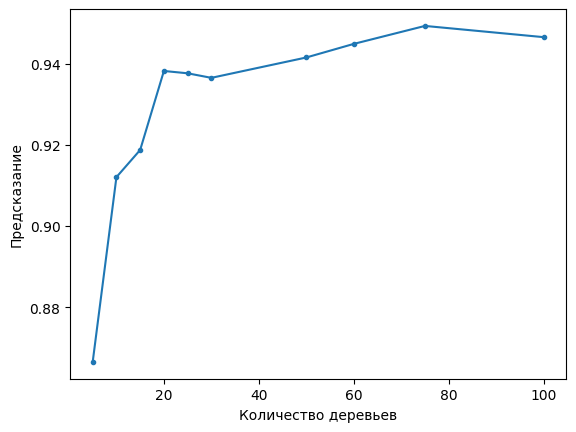

In [55]:
score = []
trees = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]
for i in trees:
    rf1 = RandomForestClassifier(n_estimators=i)
    rf1.fit(X_train, y_train)
    score.append(cross_val_score(rf1, X, y, cv=10))
score = np.asmatrix(score)

plt.plot(trees, score.mean(axis=1), marker='.')
plt.xlabel('Количество деревьев')
plt.ylabel('Предсказание')
plt.show()

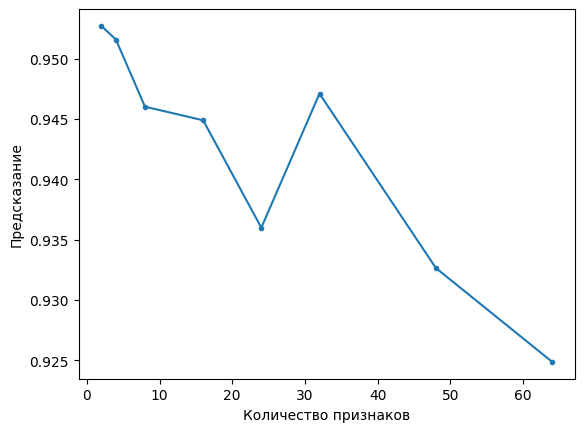

In [47]:
score = []
features = [2, 4, 8, 16, 24, 32, 48, 64]
for i in features:
    rf1 = RandomForestClassifier(n_estimators=100, max_features=i)
    rf1.fit(X_train, y_train)
    score.append(cross_val_score(rf1, X, y, cv=10))
score = np.asmatrix(score)

plt.plot(features, score.mean(axis=1), marker='.')
plt.xlabel('Количество признаков')
plt.ylabel('Предсказание')
plt.show()

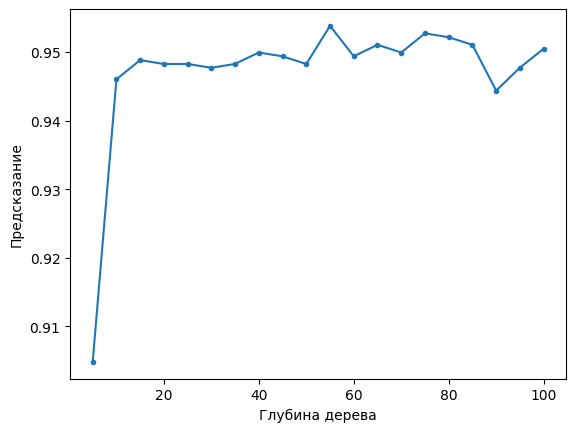

In [50]:
score = []
depth = list(range(5, 101, 5))
for i in depth:
    rf1 = RandomForestClassifier(n_estimators=100, max_depth=i)
    rf1.fit(X_train, y_train)
    score.append(cross_val_score(rf1, X, y, cv=10))
score = np.asmatrix(score)

plt.plot(depth, score.mean(axis=1), marker='.')
plt.xlabel('Глубина дерева')
plt.ylabel('Предсказание')
plt.show()